<a href="https://www.kaggle.com/code/abdulmannann/plant-diseases-detection-with-cnn?scriptVersionId=273428804" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

In [2]:
import os
data_dir = "/kaggle/input/plant-dataset/plant/PlantVillage"
print("Classes:", os.listdir(data_dir))


Classes: ['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Citrus', 'Tomato__Target_Spot', 'Pepper__bell___healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus']


# Check How Many Images in Each Class

In [3]:
base_dir = "/kaggle/input/plant-dataset/plant/PlantVillage"
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        print(f"{folder}: {len(os.listdir(folder_path))} images")

Pepper__bell___Bacterial_spot: 997 images
Potato___healthy: 152 images
Tomato_Leaf_Mold: 952 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 3209 images
Tomato_Bacterial_spot: 2127 images
Tomato_Septoria_leaf_spot: 1771 images
Tomato_healthy: 1591 images
Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
Tomato_Early_blight: 1000 images
Citrus: 103 images
Tomato__Target_Spot: 1404 images
Pepper__bell___healthy: 1478 images
Potato___Late_blight: 1000 images
Tomato_Late_blight: 1909 images
Potato___Early_blight: 1000 images
Tomato__Tomato_mosaic_virus: 373 images


# Split Data Into Train , Test And Validation

70% For Training

20% For Validation

10% For Testing

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil

2025-11-04 13:24:36.435521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762262676.640257      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762262676.695108      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
WORK_DIR = "/kaggle/working/plant_split"
TRAIN_DIR = os.path.join(WORK_DIR, "train")
VAL_DIR   = os.path.join(WORK_DIR, "val")
TEST_DIR  = os.path.join(WORK_DIR, "test")

# Split: 70% train, 15% val, 15% test

In [6]:
for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(d, exist_ok=True)
for cls in sorted(os.listdir(base_dir)):
    src_cls_dir = os.path.join(base_dir, cls)
    if not os.path.isdir(src_cls_dir):
        continue
    imgs = [f for f in os.listdir(src_cls_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    if len(imgs) == 0:
        continue
    train_imgs, temp_imgs = train_test_split(imgs, test_size=0.30, random_state=42)
    val_imgs, test_imgs   = train_test_split(temp_imgs, test_size=0.50, random_state=42)

    for split_name, img_list in zip([TRAIN_DIR, VAL_DIR, TEST_DIR], [train_imgs, val_imgs, test_imgs]):
        dst_cls_dir = os.path.join(split_name, cls)
        os.makedirs(dst_cls_dir, exist_ok=True)
        for im in img_list:
            src = os.path.join(src_cls_dir, im)
            dst = os.path.join(dst_cls_dir, im)
            shutil.copy2(src, dst)
def count_images(path):
    total=0
    for root, dirs, files in os.walk(path):
        total += sum(1 for f in files if f.lower().endswith(('.jpg','.jpeg','.png')))
    return total

print("Train Images: ", count_images(TRAIN_DIR))
print("Val   Images: ", count_images(VAL_DIR))
print("Test  Images: ", count_images(TEST_DIR))


Train Images:  14512
Val   Images:  3112
Test  Images:  3117


# Data Augmentation

# Increase DataSize With Existing Images

In [7]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_val_datagen = ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
val_gen = test_val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 14512 images belonging to 16 classes.
Found 3112 images belonging to 16 classes.
Found 3117 images belonging to 16 classes.


# Show Sample Images

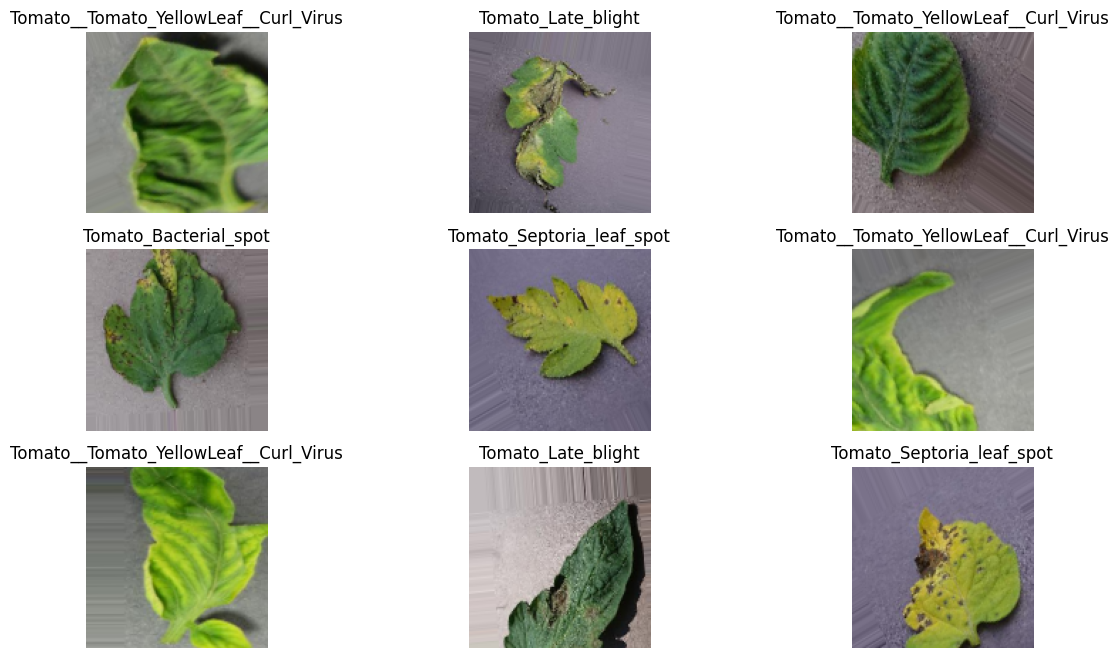

In [8]:
x,y = next(train_gen)
plt.figure(figsize=(14,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x[i])
    label_idx = np.argmax(y[i])
    label = list(train_gen.class_indices.keys())[label_idx]
    plt.title(label)
    plt.axis('off')
plt.show()


# Build CNN Model

In [9]:
from keras import models
from keras import layers

In [10]:
model=models.Sequential()

In [11]:
model.add(layers.Conv2D(32,(3, 3), activation='relu',input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(16, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762262763.079959      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         8,208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,271,504 (73.51 MB)

 Trainable params: 19,271,504 (73.51 MB)

 Non-trainable params: 0 (0.00 B)

# Compile Model

In [13]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

# Training Model

In [14]:
History = model.fit(train_gen,epochs=30,validation_data=val_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1762262767.402854      81 service.cc:148] XLA service 0x79e17400e2e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762262767.403788      81 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762262767.741486      81 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/454 ━━━━━━━━━━━━━━━━━━━━ 33s 73ms/step - acc: 0.1128 - loss: 2.9848

I0000 00:00:1762262770.880702      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


454/454 ━━━━━━━━━━━━━━━━━━━━ 71s 144ms/step - acc: 0.2786 - loss: 2.2502 - val_acc: 0.5116 - val_loss: 1.5747
Epoch 2/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 62s 137ms/step - acc: 0.6249 - loss: 1.1157 - val_acc: 0.6722 - val_loss: 1.0500
Epoch 3/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 61s 135ms/step - acc: 0.7130 - loss: 0.8533 - val_acc: 0.7188 - val_loss: 1.0561
Epoch 4/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 62s 136ms/step - acc: 0.7713 - loss: 0.6727 - val_acc: 0.7278 - val_loss: 1.0021
Epoch 5/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 60s 132ms/step - acc: 0.7961 - loss: 0.6042 - val_acc: 0.7690 - val_loss: 0.7098
Epoch 6/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 61s 134ms/step - acc: 0.8383 - loss: 0.4908 - val_acc: 0.7400 - val_loss: 1.0777
Epoch 7/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 61s 134ms/step - acc: 0.8447 - loss: 0.4567 - val_acc: 0.8400 - val_loss: 0.5425
Epoch 8/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 61s 134ms/step - acc: 0.8574 - loss: 0.4065 - val_acc: 0.7976 - val_loss: 0.7200
Epoch 9/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 61s

In [15]:
final_train_acc = History.history['acc'][-1]
final_val_acc = History.history['val_acc'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


Final Training Accuracy: 0.9433
Final Validation Accuracy: 0.9370


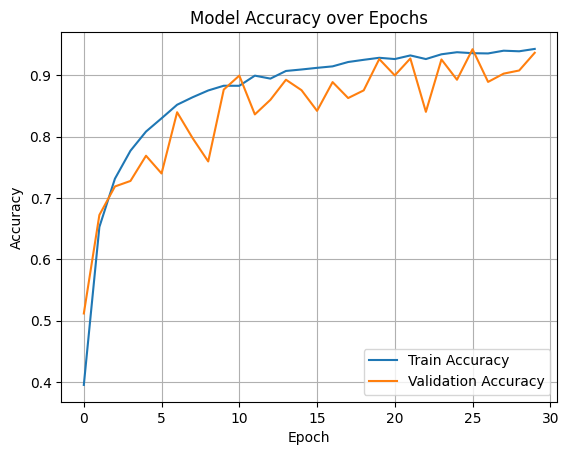

In [16]:
plt.plot(History.history['acc'], label='Train Accuracy')
plt.plot(History.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
model.save("PlantDetectionModel.h5")

In [18]:
from tensorflow.keras.models import load_model
model = load_model("PlantDetectionModel.h5")

In [19]:
class_labels = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight','Potato___healthy','Potato___Late_blight','Citrus''Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_healthy','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_mosaic_virus','Tomato__Tomato_YellowLeaf__Curl_Virus']

In [20]:
from PIL import Image
import numpy as np
img_path = "/kaggle/input/plantdisease/PlantVillage/Tomato__Target_Spot/01f0e0cb-83a7-4190-9645-bd06b70c8d65___Com.G_TgS_FL 8318.JPG"  
img = Image.open(img_path).convert('RGB') 
img = img.resize((128, 128))
img_array = np.array(img) / 255.0  
img_array = np.expand_dims(img_array, axis=0)  


In [21]:
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
print("Predicted CLass OF Plant:", class_labels[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicted CLass OF Plant: Tomato__Target_Spot
